In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as mpplt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [2]:
# load data
data_names = ['x1','x2','label']
train_data = pd.read_csv('P3a_train_data_mod.txt', names=data_names)
test_data = pd.read_csv('P3a_test_data_mod.txt', names=data_names)
train = train_data.values
test = test_data.values

# constants
NUM_TRAIN = train.shape[0]
NUM_TEST = test.shape[0]
NUM_FEATS = 1
NUM_ITERS = 1
NUM_SAMPLES = 100

# create train and test set
train_X = train[:,0:NUM_FEATS]
train_y = train[:,NUM_FEATS].astype('int')
test_X = test[:,0:NUM_FEATS]
test_y = test[:,NUM_FEATS].astype('int')
l1_idx = np.asarray([i for i in range(len(train_y)) if train_y[i] == 1], dtype='int')
l2_idx = np.asarray([i for i in range(len(train_y)) if train_y[i] == -1], dtype='int')


In [ ]:
def kldiv(p,q):
  return -p * np.log(q / p)

# actual density parameters
a_mu1 = [0,4]
a_var1 = [4,4]

a_mu2 = [8,12]
a_var2 = [5,5]

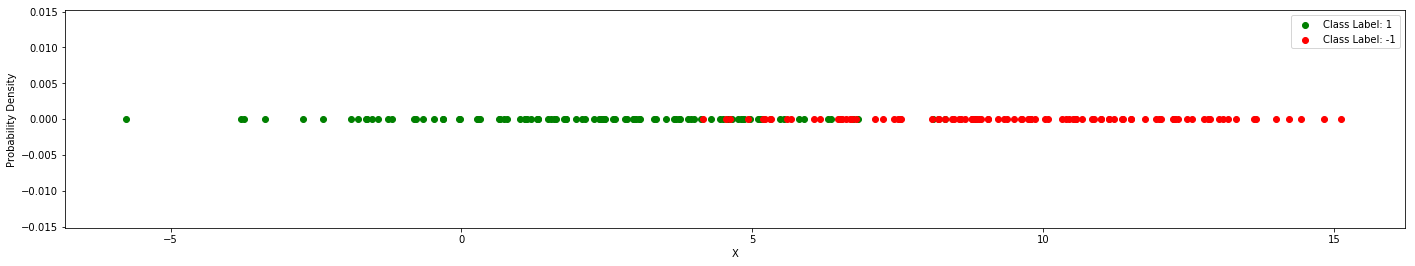

In [3]:
# plot the data points
fig = mpplt.figure(figsize=(24,4))
mpplt.scatter(train_X[l1_idx,0], np.linspace(0,0,100), c='g', label='Class Label: 1')
mpplt.scatter(train_X[l2_idx,0], np.linspace(0,0,100), c='r', label='Class Label: -1')
mpplt.xlabel('X')
mpplt.ylabel('Probability Density')
mpplt.legend()
mpplt.savefig('q311.pdf', bbox_inches='tight')

In [6]:
def plot_gaussian(data_X, theta, c_label, c_color):
  mu, var = theta[0], theta[1]
  
#   y = np.empty((data_X.shape[0]))
  x = np.linspace(-6.0,16.0,100)
  y = np.empty_like(x)
  
  for i, p in enumerate(x):
    y[i] = gaussian_density(p, mu, var)
  
  mpplt.plot(y, c=c_color, label='Class Label: '+c_label)
  mpplt.xlabel('X')
  mpplt.ylabel('Probability Density')
  mpplt.legend()
  mpplt.savefig('q321.pdf', bbox_inches='tight')
  
  return  

# acc, model = maximum_likelihood(train_X, train_y, test_X, test_y)
acc, model = maximum_likelihood(train_X, train_y, l1_idx, l2_idx, test_X, test_y)
print(model.theta_)
plot_gaussian(train_X[l1_idx], [model.theta_[1], model.sigma_[1]], '1', c_color='g')
plot_gaussian(train_X[l2_idx], [model.theta_[0], model.sigma_[0]], '-1', c_color='r')
print(acc)


NameError: name 'maximum_likelihood' is not defined

[array([ 0.55946733,  0.44053267]), array([[ 3.82634217],
       [ 0.35767464]]), array([[[ 5.09924785]],

       [[ 5.77764723]]])] 
 [array([ 0.4763041,  0.5236959]), array([[  7.56733886],
       [ 11.51192029]]), array([[[ 3.29167046]],

       [[ 2.92627073]]])]
0.925


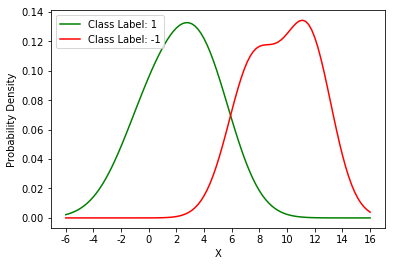

In [7]:
def plot_multimodal_gaussian(data_X, theta, c_label, c_color):
  
  x = np.linspace(-6.0,16.0,100)
  xlabel_pts = [-6,-3,0,3,6,9]
  y = np.empty_like(x)
  
  for i, p in enumerate(x):
    y[i] = f_class(p, theta)
  
  mpplt.plot(y, c=c_color, label='Class Label: '+c_label)
  mpplt.xlabel('X')
  mpplt.xticks((0,9,18,27,36,45,54,63,72,81,90,99), ('-6','-4','-2','0','2','4','6','8','10','12','14','16'))
  mpplt.ylabel('Probability Density')
  mpplt.legend()
  mpplt.savefig('q314.pdf', bbox_inches='tight')

acc, model1, model2 = gaussian_mixture_model(train_X[l1_idx], train_y[l1_idx], train_X[l2_idx],
                                 train_y[l2_idx], test_X, test_y)
plot_multimodal_gaussian(train_X[l1_idx], [model1.weights_, model1.means_, model1.covariances_], '1','g')
plot_multimodal_gaussian(train_X[l2_idx], [model2.weights_, model2.means_, model2.covariances_], '-1','r')
print(acc)



### 3.a. GMM using Expectation Maximization

In [5]:
# compute classifier accuracy
def get_accuracy(y, y_hat):
  return np.float64(sum(y == y_hat)) / np.float64(y.size)

# compute normal density at X
def gaussian_density(X, mu, var):
  y = (X - mu)**2 / (2 * var)
  return np.exp(-y) / np.sqrt(2 * np.pi * var)

# compute class conditional density at X
def f_class(X, theta):
  n1 = gaussian_density(X, theta[1][0], theta[2][0])
  n2 = gaussian_density(X, theta[1][1], theta[2][1])
  
  return theta[0][0] * n1 + theta[0][1] * n2

# use GMM to estimate component densities
def gaussian_mixture_model(train_X1, train_y1, train_X2, train_y2, test_X, test_y):
  pred_y = []
  
  # predict result for X using Bayes' Classifier
  def _bayes_classifier(test_X, test_y, params):
    for X in test_X:
      q_1 = f_class(X, params[0])
      q_2 = f_class(X, params[1])

      if(q_1 >= q_2):
        pred_y.append(1)
      else:
        pred_y.append(-1)

    return get_accuracy(test_y, pred_y)
  
  model1 = GaussianMixture(n_components=2, covariance_type='full', n_init=10, max_iter=100)
  model2 = GaussianMixture(n_components=2, covariance_type='full', n_init=10, max_iter=100)
  gmm1 = model1.fit(train_X1)
  gmm2 = model2.fit(train_X2)

  theta1 = [gmm1.weights_, gmm1.means_, gmm1.covariances_]
  theta2 = [gmm2.weights_, gmm2.means_, gmm2.covariances_]
  print(theta1,"\n" ,theta2)
  acc = _bayes_classifier(test_X, test_y, [theta1, theta2])
    
  return [acc, gmm1, gmm2]


### 3.b. Single Gaussian using MLE

In [ ]:
# compute classifier accuracy
def get_accuracy(y, y_hat):
  return np.float64(sum(y == y_hat)) / np.float64(y.size)

# compute normal density at X
def gaussian_density(X, mu, var):
  y = (X - mu)**2 / (2 * var)
  return np.exp(-y) / np.sqrt(2 * np.pi * var)

# use MLE to estimate component densities
def maximum_likelihood(train_X, train_y, test_X, test_y):
  pred_y = []
  
  # ml estimate for gaussian density
  def mle_gaussian(X):
    mu = np.mean(X, axis=0)
    sigma = np.mean((X - mu)**2)
    print(mu,sigma)
    return [mu, sigma]
  
  # predict result for X using Bayes' Classifier
  def _bayes_classifier(test_X, test_y, params):
    for X in test_X:
      q_1 = gaussian_density(X, params[0][0], params[1][0])
      q_2 = gaussian_density(X, params[0][1], params[1][1])

      if(q_1 >= q_2):
        pred_y.append(1)
      else:
        pred_y.append(-1)

    return get_accuracy(test_y, pred_y)
  
  model = GaussianNB()
  gnb = model.fit(train_X, train_y)
  theta = [gnb.theta_, gnb.sigma_]

  acc = _bayes_classifier(test_X, test_y, theta)
  print(acc)
    
  return [acc, gnb]


In [ ]:
# compute classifier accuracy
def get_accuracy(y, y_hat):
  return np.float64(sum(y == y_hat)) / np.float64(y.size)

# compute normal density at X
def gaussian_density(X, mu, var):
  y = (X - mu)**2 / (2 * var)
  return np.exp(-y) / np.sqrt(2 * np.pi * var)

# use MLE to estimate component densities
def maximum_likelihood(train_X, train_y, l1_idx, l2_idx, test_X, test_y):
  acc = np.empty((NUM_ITERS,1))
  pred_y = []
  
  # ml estimate for gaussian density
  def mle_gaussian(X):
    mu = np.mean(X, axis=0)
    sigma = np.mean((X - mu)**2)
    print(mu,sigma)
    return [mu, sigma]
  
  # predict result for X using Bayes' Classifier
  def _bayes_classifier(test_X, test_y, params):
    for X in test_X:
      q_1 = gaussian_density(X, params[0][0], params[0][1])
      q_2 = gaussian_density(X, params[1][1], params[1][1])

      if(q_1 >= q_2):
        pred_y.append(1)
      else:
        pred_y.append(-1)

    return get_accuracy(test_y, pred_y)
  
  # use ML estimate to compute parameters
  mu_1, sigma_1 = mle_gaussian(train_X[l1_idx])
  mu_2, sigma_2 = mle_gaussian(train_X[l2_idx])
  params = [[mu_1, sigma_1], [mu_2, sigma_2]]
  
  # train and predict
  acc = _bayes_classifier(test_X, test_y, params)
    
  return [acc, params]


In [ ]:
def plot_gaussian(data_X, theta, c_label, c_color):
  mu, var = theta[0], theta[1]
  
#   y = np.empty((data_X.shape[0]))
  x = np.linspace(-6.0,16.0,100)
  y = np.empty_like(x)
  
  for i, p in enumerate(x):
    y[i] = gaussian_density(p, mu, var)
  
  mpplt.plot(y, c=c_color, label='Class Label: '+c_label)
  mpplt.xlabel('X')
  mpplt.ylabel('Probability Density')
  mpplt.xticks((0,9,18,27,36,45,54,63,72,81,90,99), ('-6','-4','-2','0','2','4','6','8','10','12','14','16'))
  mpplt.legend()
  mpplt.savefig('q331.pdf', bbox_inches='tight')
  
  return  

# acc, model = maximum_likelihood(train_X, train_y, test_X, test_y)
acc, model = maximum_likelihood(train_X, train_y, l1_idx, l2_idx, test_X, test_y)
plot_gaussian(train_X[l1_idx], [model[0][0], model[0][1]], '1', c_color='g')
plot_gaussian(train_X[l2_idx], [model[1][0], model[1][1]], '-1', c_color='r')
print(acc)


### 3.c. KNN

In [ ]:
# compute classifier accuracy
def get_accuracy(y, y_hat):
  return np.float64(sum(y == y_hat)) / np.float64(y.size)

def k_nearest_neighbors(train_X, train_y, test_X, test_y):
  knc = KNeighborsClassifier(n_neighbors=5)
  model = knc.fit(train_X, train_y)
  pred_y = model.predict(test_X)
  
  return get_accuracy(test_y, pred_y)

acc3 = k_nearest_neighbors(train_X, train_y, test_X, test_y)
print(acc3)

### Load data and run classifiers

In [ ]:
# run GMM
acc1 = gaussian_mixture_model(train_X[l1_idx], train_y[l1_idx], train_X[l2_idx],
                                 train_y[l2_idx], test_X, test_y)
acc2 = maximum_likelihood(train_X, train_y, test_X, test_y)
acc3 = k_nearest_neighbors(train_X, train_y, test_X, test_y)
print("GMM: %f" % (np.mean(acc1)))
print("MLE: %f" % (np.mean(acc2)))
print("KNN: %f" % (np.mean(acc3)))